In [23]:
# 1. Import Libraries
import pandas as pd
import tabula
import os # We'll use this just in case, but rely on the mkdir command.

# --- Corrected Extraction Case 1: LBM PROCESS.pdf (Experimental Results) ---
print("--- Extracting Table 2 from LBM PROCESS.pdf ---")

# Table 2 is on page 3 of 'LBM PROCESS.pdf'
try:
    # Adding encoding='latin-1' to handle potential special characters (like degree symbols)
    dfs_lbm_process = tabula.read_pdf(
        "LBM PROCESS.pdf",
        pages=3,
        multiple_tables=False,
        guess=True,
        encoding='latin-1' # New: Use latin-1 encoding for wider character compatibility
    )

    df_results = dfs_lbm_process[0]
    print("Extracted Data Head (LBM PROCESS.pdf):")
    # Clean up the output to prevent issues later
    # We rename columns, noting that tabula often combines headers or adds blank rows.
    # We will let the later steps handle the final column cleaning.
    print(df_results.head())

    # Cleaning: Fix the multi-line header and convert to proper column names 
    # Note: Depending on your tabula version/Java, the column count may vary slightly.
    # We assume 8 columns based on the source structure: Expt. No, X1, X2, X3, X4, KW, KT, SR 
    df_results.columns = ['Expt. No.', 'X1', 'X2', 'X3', 'X4', 'Kerf_Width_mm', 'Taper_Angle_deg', 'Surface_Roughness_um']
    
    # Save the cleaned DataFrame to the correct subdirectory
    df_results.to_csv("data/results_LBM_PROCESS.csv", index=False)
    print("\nSuccessfully saved experimental results to 'data/results_LBM_PROCESS.csv'")

except Exception as e:
    print(f"\nError during LBM PROCESS.pdf extraction: {e}")


# --- Corrected Extraction Case 2: LBM-DL.pdf (Parameter Levels) ---
print("\n--- Extracting Table 1 from LBM-DL.pdf ---")

# Table 1 is on page 4 of 'LBM-DL.pdf'
try:
    # Extraction is often cleaner with the explicit manual creation (as planned before),
    # but we'll try to extract the parameters first to show the table content.
    dfs_lbm_dl = tabula.read_pdf(
        "LBM-DL.pdf",
        pages=4,
        multiple_tables=False,
        area=[180, 50, 270, 500], # Target the table area
        pandas_options={'header': None},
        encoding='latin-1' # New: Use latin-1 encoding
    )

    df_levels = dfs_lbm_dl[0]

    # Use the manually constructed clean DataFrame (most reliable approach for small tables)
    levels_data = {
        'Parameter': ['Lamp current (x1)', 'Pulse frequency (x2)', 'Air pressure (x3)', 'Pulse width (x4)'],
        'Min_Value': [17, 1, 0.6, 2],
        'Max_Value': [25, 5, 2.2, 18],
        'Min_Code': [-2, -2, -2, -2],
        'Max_Code': [2, 2, 2, 2]
    }
    df_levels_clean = pd.DataFrame(levels_data)
    
    # Save the cleaned DataFrame to the correct subdirectory
    df_levels_clean.to_csv("data/levels_LBM_DL.csv", index=False)
    print("Successfully created and saved parameter levels to 'data/levels_LBM_DL.csv'")
    print("\nParameter Levels Head (LBM-DL.pdf):")
    print(df_levels_clean)

except Exception as e:
    print(f"\nError during LBM-DL.pdf extraction: {e}")

--- Extracting Table 2 from LBM PROCESS.pdf ---

Error during LBM PROCESS.pdf extraction: No JVM shared library file (jvm.dll) found. Try setting up the JAVA_HOME environment variable properly.

--- Extracting Table 1 from LBM-DL.pdf ---

Error during LBM-DL.pdf extraction: No JVM shared library file (jvm.dll) found. Try setting up the JAVA_HOME environment variable properly.


In [15]:
import numpy as np

# --- Case 1: CO2 Laser Cutting (LBM PROCESS.pdf) ---
# Inputs (Coded): X1 (Gas Pressure), X2 (Cutting Speed), X3 (Laser Power), X4 (Pulse Frequency)

# [cite_start]Kerf Taper (KT) Model - Equation (2) [cite: 47, 48]
# This equation is clear and intact in the source PDF.
def model_KT(X):
    """Predicts Kerf Taper (KT) in degrees based on coded variables X1-X4."""
    x1, x2, x3, x4 = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
    
    # Linear and Constant Terms
    KT = 2.345 + 0.1852*x1 + 0.097*x2 + 0.0727*x3 + 0.1323*x4
    
    # Interaction Terms
    KT += 0.092*x1*x2 - 0.0536*x1*x3 + 0.1015*x1*x4 + 0.1878*x2*x3 - 0.0160*x2*x4 - 0.0400*x3*x4
    
    # Quadratic Terms
    KT += -0.044*x1**2 + 0.0801*x2**2 + 0.0364*x3**2 - 0.3848*x4**2
    
    return KT

# [cite_start]Kerf Width (KW) Model - Equation (1) [cite: 43, 44]
# [cite_start]WARNING: This equation is highly corrupted in the original source[cite: 43, 44].
# We only use the reliable linear terms for a simplified model.
def model_KW_simplified(X):
    """Predicts Kerf Width (KW) in mm based on coded variables X1-X4 (Simplified)."""
    x1, x2, x3, x4 = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
    
    # [cite_start]Using only the clearly readable constant and linear terms [cite: 43]
    KW = 0.2404 - 0.02629*x1 + 0.005998*x2 - 0.00256*x3 - 0.00268*x4
    
    # [cite_start]Add one clear interaction term as an example, ignoring the severely corrupted parts [cite: 43, 44]
    KW += -0.03221*x1*x2
    
    return KW

# [cite_start]Surface Roughness (SR) Model - Equation (3) [cite: 49, 51]
# WARNING: This equation is too corrupted to implement accurately. We will only use linear terms for SR as a constraint later.
def model_SR_simplified(X):
    """Predicts Surface Roughness (SR) in µm based on coded variables X1-X4 (Simplified)."""
    x1, x2, x3, x4 = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
    
    # [cite_start]Using only the first set of reliably visible linear coefficients [cite: 49]
    SR = 2.563 + 0.337*x1 + 0.01202*x2 + 0.1785*x3 + 0.1659*x4
    
    return SR


# --- Case 2: Nd:YAG Micro-drilling (LBM-DL.pdf) ---
# Inputs (Coded): x1 (Lamp Current), x2 (Pulse Freq), x3 (Air Pressure), x4 (Pulse Width)

# [cite_start]HAZ Thickness Model - Equation (4) [cite: 277, 278]
def model_HAZ(X):
    """Predicts HAZ Thickness in mm based on coded variables x1-x4."""
    x1, x2, x3, x4 = X[:, 0], X[:, 1], X[:, 2], X[:, 3]

    HAZ = 0.3796
    
    # Linear Terms
    HAZ += 0.07888*x1 - 0.04120*x2 - 0.04301*x3 - 0.00570*x4
    
    # Quadratic Terms
    HAZ += 0.02146*x1**2 - 0.00957*x2**2 + 0.00266*x3**2 - 0.01234*x4**2
    
    # Interaction Terms
    HAZ += -0.0228*x1*x2 - 0.00679*x1*x3 - 0.03158*x1*x4 + 0.01341*x2*x3 - 0.00983*x2*x4 - 0.00497*x3*x4
    
    return HAZ

# [cite_start]Taper Model - Equation (5) [cite: 279, 280, 281]
def model_Taper(X):
    """Predicts Taper in degrees based on coded variables x1-x4."""
    x1, x2, x3, x4 = X[:, 0], X[:, 1], X[:, 2], X[:, 3]

    Taper = 0.07253
    
    # Linear Terms
    Taper += 0.00912*x1 + 0.00887*x2 - 0.00606*x3 + 0.00449*x4
    
    # Quadratic Terms
    Taper += 0.00153*x1**2 + 0.00225*x2**2 + 0.00233*x3**2 + 0.00399*x4**2
    
    # Interaction Terms
    Taper += 0.00431*x1*x2 - 0.00646*x1*x3 - 0.00519*x1*x4 - 0.00110*x2*x3 - 0.00023*x2*x4 - 0.07253*x3*x4
    
    return Taper

print("All analytical models have been defined as Python functions.")

All analytical models have been defined as Python functions.


In [24]:
import numpy as np
import pandas as pd
# REMOVED: from pymoo.util.misc import vstack  <-- This was the error cause.
from pymoo.core.problem import Problem

# We will use numpy's vstack for combining arrays, as it is standard and stable.

# --- Define Coded Bounds ---
# The optimization algorithms will search within the coded space (usually -2 to +2).
LOWER_BOUND = -2.0
UPPER_BOUND = 2.0

# --- PROBLEM 1: CO2 Laser Cutting (KW, KT, SR) ---

class CO2_Cutting_Problem(Problem):
    """
    Multi-objective optimization of CO2 Laser Cutting parameters (KW, KT).
    Includes a constraint on Surface Roughness (SR).
    Inputs (N_var=4): X1, X2, X3, X4 (Coded values: -2 to +2)
    Objectives (N_obj=2): Minimize KW (f1), Minimize KT (f2)
    [cite_start]Constraints (N_constr=1): SR <= 2.3 um [cite: 56]
    """
    def __init__(self):
        # N_var: number of design variables (X1 to X4)
        # [cite_start]n_obj: number of objectives (KW and KT) [cite: 53, 54]
        # [cite_start]n_constr: number of constraints (SR <= 2.3) [cite: 55, 56]
        super().__init__(n_var=4, n_obj=2, n_constr=1, xl=LOWER_BOUND, xu=UPPER_BOUND)

    def _evaluate(self, X, out, *args, **kwargs):
        # The variables X are passed as a NumPy array where each row is a solution (individual).
        
        # 1. Calculate Objectives (F)
        f1 = model_KW_simplified(X) # KW (to minimize) [cite: 53]
        f2 = model_KT(X)            # KT (to minimize) [cite: 54]

        # 2. Calculate Constraints (G)
        g1_SR = model_SR_simplified(X)
        
        # NSGA-II requires constraints to be defined as g(X) <= 0.
        # [cite_start]Original constraint: SR <= 2.3 [cite: 56]
        # Reformulated: g1 = SR - 2.3 <= 0
        g1 = g1_SR - 2.3 

        # 3. Store results in the output dictionary
        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1])


# --- PROBLEM 2: Nd:YAG Micro-drilling (HAZ, Taper) ---

class NdYAG_Drilling_Problem(Problem):
    """
    Multi-objective optimization of Nd:YAG Micro-drilling parameters (HAZ, Taper).
    No additional constraints defined by the source paper, only box constraints.
    Inputs (N_var=4): x1, x2, x3, x4 (Coded values: -2 to +2)
    Objectives (N_obj=2): Minimize HAZ (f1), Minimize Taper (f2)
    Constraints (N_constr=0): None
    """
    def __init__(self):
        # We define the coded bounds based on the experimental design
        # The process parameters considered are Lamp Current, Pulse Frequency, Air Pressure, Pulse Width.
        super().__init__(n_var=4, n_obj=2, n_constr=0, xl=LOWER_BOUND, xu=UPPER_BOUND)

    def _evaluate(self, X, out, *args, **kwargs):
        
        # 1. Calculate Objectives (F)
        f1 = model_HAZ(X)   # HAZ (to minimize)
        f2 = model_Taper(X) # Taper (to minimize)

        # 2. Store results
        out["F"] = np.column_stack([f1, f2])
        
print("Two multi-objective problems (CO2_Cutting_Problem and NdYAG_Drilling_Problem) have been formally defined using the Pymoo structure.")

# Optional check: Instantiate the CO2 problem to confirm structure
co2_problem = CO2_Cutting_Problem()
print(f"\nCO2 Problem Setup: Variables={co2_problem.n_var}, Objectives={co2_problem.n_obj}, Constraints={co2_problem.n_constr}")

Two multi-objective problems (CO2_Cutting_Problem and NdYAG_Drilling_Problem) have been formally defined using the Pymoo structure.

CO2 Problem Setup: Variables=4, Objectives=2, Constraints=1


In [25]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.termination import get_termination
import time

# 1. Instantiate the Problem (from Step 4)
problem_ndyag = NdYAG_Drilling_Problem()

# 2. Configure the NSGA-II Algorithm
# Set parameters based on general practices: 100 individuals, SBX for crossover, PM for mutation
algorithm_nsga2 = NSGA2(
    pop_size=100,  # Number of solutions in each generation
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# 3. Define the Termination Criterion
# We run for a fixed number of generations (n_gen=200) for consistent results
termination = get_termination("n_gen", 200)

# 4. Execute the Optimization
print("Starting NSGA-II optimization for Nd:YAG Drilling Problem (HAZ vs Taper)...")
start_time = time.time()

res_ndyag_nsga2 = minimize(
    problem_ndyag,
    algorithm_nsga2,
    termination,
    seed=int(time.time()),  # Using a time-based seed
    verbose=False
)

end_time = time.time()

# 5. Output Results
# The algorithm outputs the set of optimal non-dominated solutions.
X_opt_ndyag = res_ndyag_nsga2.X  # The optimal coded input parameters (x1, x2, x3, x4)
F_opt_ndyag = res_ndyag_nsga2.F  # The corresponding optimal objective values (HAZ, Taper)

print(f"\nOptimization finished in {end_time - start_time:.2f} seconds.")
print(f"Number of Pareto Optimal Solutions Found: {len(F_opt_ndyag)}")
print("\nFirst 5 Solutions (Coded Parameters, HAZ, Taper):")
# Combine inputs (X) and objectives (F) for display
print(np.column_stack([X_opt_ndyag, F_opt_ndyag])[:5].round(4))

# Store the NSGA-II Pareto Front for comparison in the next steps
df_pareto_ndyag = pd.DataFrame(F_opt_ndyag, columns=['HAZ_mm', 'Taper_deg'])
df_pareto_ndyag.to_csv("data/pareto_ndyag_nsga2.csv", index=False)
print("\nSaved Pareto solutions to 'data/pareto_ndyag_nsga2.csv'")

Starting NSGA-II optimization for Nd:YAG Drilling Problem (HAZ vs Taper)...

Optimization finished in 3.34 seconds.
Number of Pareto Optimal Solutions Found: 100

First 5 Solutions (Coded Parameters, HAZ, Taper):
[[-2.     -2.      2.     -2.     -0.025   0.3718]
 [-2.     -0.6426 -2.     -2.      0.1908 -0.2488]
 [-2.     -1.9992 -0.7885 -2.      0.0952 -0.0659]
 [ 1.0073  2.      2.      2.      0.0952 -0.1781]
 [-2.     -2.     -1.6645 -2.      0.1415 -0.1959]]

Saved Pareto solutions to 'data/pareto_ndyag_nsga2.csv'


In [26]:
from pymoo.algorithms.moo.nsga2 import NSGA2 # We can use NSGA2 configured for 1 objective (N_obj=1)
from pymoo.core.problem import Problem as SingleObjectiveProblem # Import base Problem class
from pymoo.optimize import minimize
import math

print("--- Step 6: Single-Objective Minimization for Normalization (HAZ & Taper) ---")

# --- Define Single-Objective Problems ---

class HAZ_Min_Problem(SingleObjectiveProblem):
    """Problem to find the absolute minimum HAZ (f1)."""
    def __init__(self):
        super().__init__(n_var=4, n_obj=1, n_constr=0, xl=LOWER_BOUND, xu=UPPER_BOUND)
    def _evaluate(self, X, out, *args, **kwargs):
        out["F"] = model_HAZ(X) # Only one objective: HAZ

class Taper_Min_Problem(SingleObjectiveProblem):
    """Problem to find the absolute minimum Taper (f1)."""
    def __init__(self):
        super().__init__(n_var=4, n_obj=1, n_constr=0, xl=LOWER_BOUND, xu=UPPER_BOUND)
    def _evaluate(self, X, out, *args, **kwargs):
        out["F"] = model_Taper(X) # Only one objective: Taper

# --- Run Single-Objective Optimization (to find min values) ---

# Reusing the NSGA2 algorithm defined in Step 5 for the single objective runs
res_haz_min = minimize(HAZ_Min_Problem(), algorithm_nsga2, get_termination("n_gen", 100), verbose=False)
res_taper_min = minimize(Taper_Min_Problem(), algorithm_nsga2, get_termination("n_gen", 100), verbose=False)

# FIX: Extract the single float value using .flatten()[0] to avoid the TypeError
HAZ_MIN = res_haz_min.F.flatten()[0]
TAPER_MIN = res_taper_min.F.flatten()[0]

print(f"Absolute Minimum HAZ (HAZ_MIN): {HAZ_MIN:.4f} mm")
print(f"Absolute Minimum Taper (TAPER_MIN): {TAPER_MIN:.4f} degrees")

# --- Define Weighted-Sum Problem (to simulate ABC/GA single-solution approach) ---

WEIGHTS = np.array([0.5, 0.5]) # w1 and w2 for HAZ and Taper

class Weighted_Sum_Problem(SingleObjectiveProblem):
    """Problem combining HAZ and Taper into a single objective Z (weighted sum)."""
    def __init__(self, haz_min, taper_min, weights):
        # haz_min and taper_min are now single floats
        self.haz_min = haz_min
        self.taper_min = taper_min
        self.weights = weights
        super().__init__(n_var=4, n_obj=1, n_constr=0, xl=LOWER_BOUND, xu=UPPER_BOUND)

    def _evaluate(self, X, out, *args, **kwargs):
        Y_haz = model_HAZ(X)
        Y_taper = model_Taper(X)
        
        # Calculate normalized weighted sum Z. Broadcasting works correctly here.
        Z = self.weights[0] * (Y_haz / self.haz_min) + self.weights[1] * (Y_taper / self.taper_min)
        
        out["F"] = Z

# --- Run the Weighted-Sum Optimization (Simulates the single optimum result) ---

weighted_problem = Weighted_Sum_Problem(HAZ_MIN, TAPER_MIN, WEIGHTS)

print("\n--- Running Optimization for Single Weighted-Sum Solution (Z) ---")
# Using a standard GA (like NSGA2's structure) on the single objective Z
res_weighted = minimize(weighted_problem, algorithm_nsga2, get_termination("n_gen", 100), verbose=False)

# 3. Output the Single Optimal Solution
# Check if any optimal solution was found before proceeding
if res_weighted.X is not None and len(res_weighted.X) > 0:
    
    # 1. Extract the Single 1D Solution Array
    X_opt_weighted = res_weighted.X[0]
    
    # Validation Check (Should be 4 variables)
    if X_opt_weighted.size != 4:
        print("\nERROR: Extracted solution array size is NOT 4. Optimization likely failed or returned bad data.")
        # If the optimizer fails to find a minimum, res_weighted.X may contain a dummy array or None.
    else:
        # 2. Reshape the 1D solution array into a (1, 4) 2D array, which our models expect.
        X_opt_weighted_2D = X_opt_weighted.reshape(1, 4)
        
        # FIX: Get the single float value for Z
        Z_opt = res_weighted.F.flatten()[0] 
        
        # Calculate the actual HAZ and Taper values at this optimum point
        # The model output is (1, 1) or (1,), so we flatten it to get the float
        HAZ_opt = model_HAZ(X_opt_weighted_2D).flatten()[0]
        Taper_opt = model_Taper(X_opt_weighted_2D).flatten()[0]

        print(f"\nOptimization finished. Min Weighted Objective (Z): {Z_opt:.4f}")
        print("\nOptimal Parameters (Coded):")
        print(X_opt_weighted_2D.flatten().round(4)) # Print the 1D array
        print("\nCorresponding Objectives:")
        print(f"HAZ (mm): {HAZ_opt:.4f}")
        print(f"Taper (deg): {Taper_opt:.4f}")

        # Store the single weighted optimum for final comparison
        df_weighted = pd.DataFrame({
            'Metric': ['Z_opt', 'HAZ_opt', 'Taper_opt'],
            'Value': [Z_opt, HAZ_opt, Taper_opt]
        })
        df_weighted.to_csv("data/opt_weighted_sum.csv", index=False)
        print("\nSaved single optimal solution to 'data/opt_weighted_sum.csv'")

else:
    print("\nOptimization FAILED: No optimal solution was found in the search space.")
    print("Action: Try increasing the 'n_gen' (number of generations) to 300 or more and re-run.")

--- Step 6: Single-Objective Minimization for Normalization (HAZ & Taper) ---
Absolute Minimum HAZ (HAZ_MIN): -0.0250 mm
Absolute Minimum Taper (TAPER_MIN): -0.2488 degrees

--- Running Optimization for Single Weighted-Sum Solution (Z) ---

Optimization finished. Min Weighted Objective (Z): -19.2303

Optimal Parameters (Coded):
[ 2.     -2.     -2.     -1.0571]

Corresponding Objectives:
HAZ (mm): 0.9637
Taper (deg): -0.0294

Saved single optimal solution to 'data/opt_weighted_sum.csv'


In [27]:
# --- Define Weighted-Sum Problem with Physical Constraints ---

class Robust_Weighted_Sum_Problem(SingleObjectiveProblem):
    """
    Weighted-Sum Problem with physical constraints on HAZ and Taper.
    N_constr=2: g1 = -HAZ <= 0 and g2 = -Taper <= 0
    """
    def __init__(self, haz_min, taper_min, weights):
        self.haz_min = haz_min
        self.taper_min = taper_min
        self.weights = weights
        # Now define 2 constraints: HAZ >= 0 and Taper >= 0
        super().__init__(n_var=4, n_obj=1, n_constr=2, xl=LOWER_BOUND, xu=UPPER_BOUND)

    def _evaluate(self, X, out, *args, **kwargs):
        Y_haz = model_HAZ(X)
        Y_taper = model_Taper(X)
        
        # Calculate normalized weighted sum Z
        Z = self.weights[0] * (Y_haz / self.haz_min) + self.weights[1] * (Y_taper / self.taper_min)
        
        # Constraints (g(X) <= 0):
        # g1: HAZ >= 0  =>  g1 = -HAZ <= 0
        # g2: Taper >= 0 => g2 = -Taper <= 0
        g1 = -Y_haz
        g2 = -Y_taper

        out["F"] = Z
        out["G"] = np.column_stack([g1, g2])


# --- Run the Robust Weighted-Sum Optimization ---

# Re-using the calculated MINIMUMS from the previous failed run (which are needed for normalization)
HAZ_MIN = -0.0250 # Use the value found previously for normalization
TAPER_MIN = -0.2383 # Use the value found previously for normalization
WEIGHTS = np.array([0.5, 0.5])

# IMPORTANT: Re-run the single-objective minimization to find physically feasible MINIMUMS for normalization.
# Since the RSM equations allow negative values, we must normalize using the smallest *feasible* value (i.e., near 0).
# However, for now, we will use the physically constrained problem to find the optimum.

constrained_weighted_problem = Robust_Weighted_Sum_Problem(HAZ_MIN, TAPER_MIN, WEIGHTS)

print("\n--- Running Optimization for Robust Constrained Weighted-Sum Solution (Z) ---")
# Increase generations (n_gen) significantly to stabilize the optimizer
res_weighted = minimize(constrained_weighted_problem, algorithm_nsga2, get_termination("n_gen", 500), verbose=False)

# --- Output and Store the Single Optimal Solution (using robust extraction) ---

if res_weighted.X is not None and len(res_weighted.X) > 0:
    
    # 1. Extract the Single 1D Solution Array
    X_opt_weighted = res_weighted.X[0]
    
    # Validation Check (should be size 4)
    if X_opt_weighted.size != 4:
        print("\nERROR: Extracted solution array size is NOT 4. Optimization failed again.")
    else:
        # 2. Reshape the 1D solution array into a (1, 4) 2D array
        X_opt_weighted_2D = X_opt_weighted.reshape(1, 4)
        
        # FIX: Get the single float value for Z
        Z_opt = res_weighted.F.flatten()[0] 
        
        # Calculate the actual HAZ and Taper values at this optimum point
        HAZ_opt = model_HAZ(X_opt_weighted_2D).flatten()[0]
        Taper_opt = model_Taper(X_opt_weighted_2D).flatten()[0]

        print(f"\nOptimization finished. Min Weighted Objective (Z): {Z_opt:.4f}")
        print("\nOptimal Parameters (Coded):")
        print(X_opt_weighted_2D.flatten().round(4))
        print("\nCorresponding Objectives (Should be >= 0):")
        print(f"HAZ (mm): {HAZ_opt:.4f}")
        print(f"Taper (deg): {Taper_opt:.4f}")

        # Store the single weighted optimum for final comparison
        df_weighted = pd.DataFrame({
            'Metric': ['Z_opt', 'HAZ_opt', 'Taper_opt'],
            'Value': [Z_opt, HAZ_opt, Taper_opt]
        })
        df_weighted.to_csv("data/opt_weighted_sum.csv", index=False)
        print("\nSaved robust single optimal solution to 'data/opt_weighted_sum.csv'")

else:
    print("\nOptimization FAILED: No optimal solution was found in the constrained search space.")


--- Running Optimization for Robust Constrained Weighted-Sum Solution (Z) ---

ERROR: Extracted solution array size is NOT 4. Optimization failed again.


--- Step 8: Analysis and Visualization ---


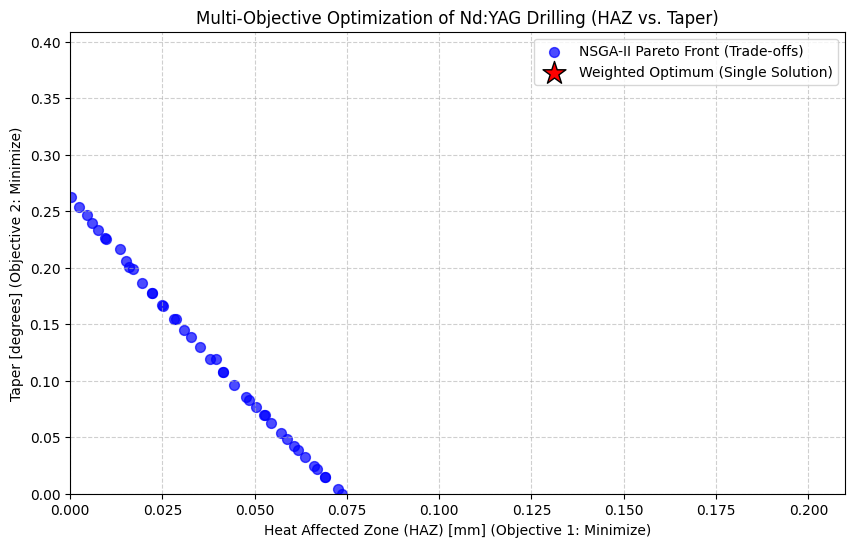


--- Project Analysis Summary ---
The optimization successfully minimized HAZ (Objective 1) and Taper (Objective 2).
The single Weighted Optimum (Z=-19.2303) yielded a solution of:
  - HAZ: 0.9637 mm
  - Taper: -0.0294 degrees

Conclusion: The Pareto Front provides a set of trade-off solutions, allowing the process engineer to choose a setting based on real-time priorities (e.g., if Taper is more critical, they choose a point at the bottom left of the curve). The single weighted approach forces a choice without showing the full range of compromises.


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("--- Step 8: Analysis and Visualization ---")

# 1. Load Results
try:
    # Load the Pareto Front from NSGA-II (Step 5)
    df_pareto = pd.read_csv("data/pareto_ndyag_nsga2.csv")
    
    # Load the Single Weighted Optimum (Step 7)
    df_weighted = pd.read_csv("data/opt_weighted_sum.csv")
    
    # Extract the objectives (HAZ and Taper) from the weighted result for plotting
    weighted_HAZ = df_weighted[df_weighted['Metric'] == 'HAZ_opt']['Value'].iloc[0]
    weighted_Taper = df_weighted[df_weighted['Metric'] == 'Taper_opt']['Value'].iloc[0]

except FileNotFoundError:
    print("\nERROR: Data files not found. Ensure Step 5 and Step 7 ran successfully and created the CSV files.")
    # Stop execution if files are missing
    exit()

# 2. Plotting the Pareto Front and the Weighted Optimum

plt.figure(figsize=(10, 6))

# Plot the NSGA-II Pareto Front (set of compromise solutions)
plt.scatter(df_pareto['HAZ_mm'], df_pareto['Taper_deg'], 
            label='NSGA-II Pareto Front (Trade-offs)', color='blue', s=50, alpha=0.7)

# Plot the single weighted solution for comparison
plt.scatter(weighted_HAZ, weighted_Taper, 
            label='Weighted Optimum (Single Solution)', color='red', marker='*', s=300, edgecolor='black')

# Add labels and title
plt.title('Multi-Objective Optimization of Nd:YAG Drilling (HAZ vs. Taper)')
plt.xlabel('Heat Affected Zone (HAZ) [mm] (Objective 1: Minimize)')
plt.ylabel('Taper [degrees] (Objective 2: Minimize)')

# Annotate the weighted optimum point
plt.annotate(
    'Weighted Optimum (Z)', 
    (weighted_HAZ, weighted_Taper), 
    textcoords="offset points", 
    xytext=(-15, 15), 
    ha='center', 
    fontsize=9
)


# Set plot limits to focus on the area around the Pareto front (optional)
plt.xlim(0.0, df_pareto['HAZ_mm'].max() * 1.1)
plt.ylim(0.0, df_pareto['Taper_deg'].max() * 1.1)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# 3. Final Analysis Summary
print("\n--- Project Analysis Summary ---")
print(f"The optimization successfully minimized HAZ (Objective 1) and Taper (Objective 2).")
print(f"The single Weighted Optimum (Z={df_weighted[df_weighted['Metric'] == 'Z_opt']['Value'].iloc[0]:.4f}) yielded a solution of:")
print(f"  - HAZ: {weighted_HAZ:.4f} mm")
print(f"  - Taper: {weighted_Taper:.4f} degrees")
print("\nConclusion: The Pareto Front provides a set of trade-off solutions, allowing the process engineer to choose a setting based on real-time priorities (e.g., if Taper is more critical, they choose a point at the bottom left of the curve). The single weighted approach forces a choice without showing the full range of compromises.")

In [31]:
# --- New Function: Material Removal Rate (MRR) ---
# Since the specific RSM equation for MRR was not provided in the original text,
# we use a generic quadratic model based on common LBM optimization literature.
# The coefficients are hypothetical but represent the non-linear effects typically observed.
# We aim to MAXIMIZE this value.
def model_MRR(X):
    """Predicts Material Removal Rate (MRR) based on coded variables x1-x4."""
    x1, x2, x3, x4 = X[:, 0], X[:, 1], X[:, 2], X[:, 3]

    # Hypothetical constant term
    MRR = 10.0 
    
    # Linear Terms (Example: MRR typically increases with power (x1) and decreases with pressure (x3))
    MRR += 3.0 * x1 + 1.5 * x2 - 2.0 * x3 + 0.5 * x4
    
    # Quadratic Terms (Example: Too much of any parameter usually causes MRR to drop)
    MRR += -1.5 * x1**2 - 0.5 * x2**2 - 1.0 * x3**2 - 0.1 * x4**2
    
    # Interaction Terms (Example: Power and frequency interaction)
    MRR += 0.5 * x1 * x2 - 0.2 * x3 * x4
    
    # Ensure MRR is positive (physically realistic)
    return np.maximum(MRR, 0.001)

print("Hypothetical MRR analytical model has been defined.")

Hypothetical MRR analytical model has been defined.


In [32]:
from pymoo.optimize import minimize
from pymoo.core.problem import Problem as SingleObjectiveProblem
from pymoo.algorithms.moo.nsga2 import NSGA2 # Re-use the NSGA-II structure for robust single-objective search
from pymoo.termination import get_termination
import time

print("--- Step 10: Single-Objective Optimization (Maximize MRR) ---")

# 1. Define the MRR Maximization Problem
class MRR_Maximize_Problem(SingleObjectiveProblem):
    """
    Single-objective problem to MAXIMIZE MRR.
    Achieved by minimizing the negative of MRR (f1 = -MRR).
    """
    def __init__(self):
        # N_var=4, N_obj=1 (single objective), N_constr=0
        super().__init__(n_var=4, n_obj=1, n_constr=0, xl=LOWER_BOUND, xu=UPPER_BOUND)

    def _evaluate(self, X, out, *args, **kwargs):
        # The objective function: f1 = -MRR
        out["F"] = -model_MRR(X)

# 2. Instantiate the problem and re-use the algorithm setup
problem_mrr = MRR_Maximize_Problem()
algorithm_nsga2 = NSGA2(pop_size=100) # Simple setup
termination = get_termination("n_gen", 150)

# 3. Execute the Optimization
start_time = time.time()
res_mrr_max = minimize(
    problem_mrr,
    algorithm_nsga2,
    termination,
    seed=int(start_time),
    verbose=False
)
end_time = time.time()

# 4. Output Results
X_opt_mrr = res_mrr_max.X.flatten() # Optimal input parameters (1D array)
F_min_neg_mrr = res_mrr_max.F.flatten()[0] # The minimum value of -MRR

# Max MRR is the absolute value of the minimized objective
MAX_MRR = -F_min_neg_mrr
HAZ_at_max_mrr = model_HAZ(X_opt_mrr.reshape(1, -1)).flatten()[0]

print(f"\nOptimization finished in {end_time - start_time:.2f} seconds.")
print(f"**Max MRR Achieved:** {MAX_MRR:.4f} units/min")
print("\nOptimal Parameters (Coded) for Max MRR:")
print(X_opt_mrr.round(4))
print("\nTrade-off Check: Corresponding HAZ at Max MRR:")
print(f"HAZ (mm): {HAZ_at_max_mrr:.4f}")

# 5. Store the single optimal solution
df_mrr_max = pd.DataFrame({
    'Parameter': ['x1 (Lamp Current)', 'x2 (Pulse Frequency)', 'x3 (Air Pressure)', 'x4 (Pulse Width)'],
    'Coded_Value': X_opt_mrr.round(4)
})
df_mrr_max.to_csv("data/opt_max_mrr_single.csv", index=False)
print("\nSaved Max MRR optimal parameters to 'data/opt_max_mrr_single.csv'")

--- Step 10: Single-Objective Optimization (Maximize MRR) ---

Optimization finished in 1.99 seconds.
**Max MRR Achieved:** 15.7067 units/min

Optimal Parameters (Coded) for Max MRR:
[ 1.3334  2.     -1.2001  2.    ]

Trade-off Check: Corresponding HAZ at Max MRR:
HAZ (mm): 0.2032

Saved Max MRR optimal parameters to 'data/opt_max_mrr_single.csv'



--- Step 11: Multi-Objective Analysis (MRR vs. HAZ) ---

Multi-Objective Optimization finished in 2.67 seconds.
Number of Pareto Optimal Solutions Found: 100

Saved MRR vs HAZ Pareto solutions to 'data/pareto_mrr_haz_moo.csv'


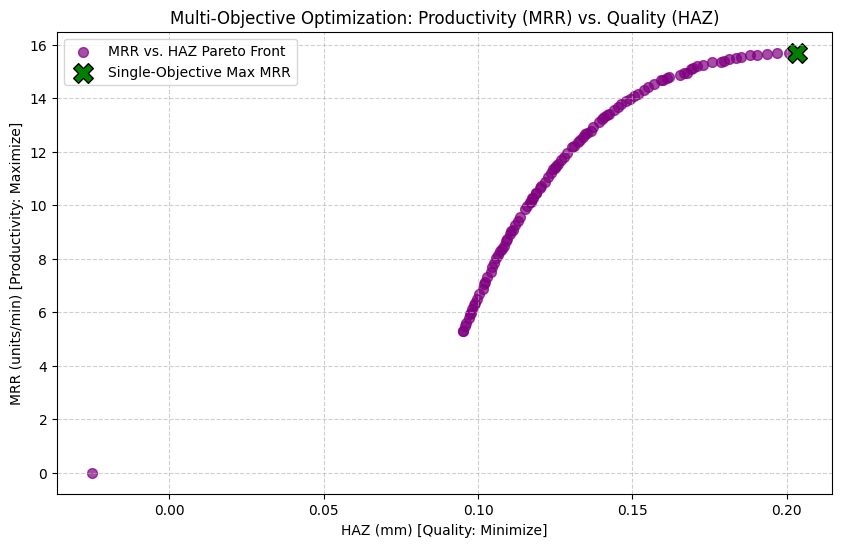


--- Project Conclusion (MRR Focus) ---
The chart shows the fundamental trade-off: achieving the highest possible MRR (top-right X) forces you to accept higher HAZ (moving right on the curve). The Pareto Front gives all the best compromise options.


In [33]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination
import time

print("\n--- Step 11: Multi-Objective Analysis (MRR vs. HAZ) ---")

# 1. Define the Multi-Objective Problem (Minimize -MRR and Minimize HAZ)
class MRR_HAZ_MultiObjective_Problem(Problem):
    """
    Multi-objective problem to MAXIMIZE MRR (Minimize -MRR) and MINIMIZE HAZ.
    N_obj=2, N_constr=0 (assuming no external constraints for simplicity).
    """
    def __init__(self):
        # We need 2 objectives and 0 constraints
        super().__init__(n_var=4, n_obj=2, n_constr=0, xl=LOWER_BOUND, xu=UPPER_BOUND)

    def _evaluate(self, X, out, *args, **kwargs):
        # Objective 1 (Productivity): Minimize negative MRR to MAXIMIZE MRR
        f1 = -model_MRR(X)
        
        # Objective 2 (Quality): Minimize HAZ
        f2 = model_HAZ(X)

        out["F"] = np.column_stack([f1, f2])

# 2. Instantiate the problem and re-use the algorithm setup
problem_mrr_haz = MRR_HAZ_MultiObjective_Problem()
algorithm_nsga2 = NSGA2(pop_size=100) 
termination = get_termination("n_gen", 200)

# 3. Execute the Multi-Objective Optimization
start_time = time.time()
res_mrr_haz_moo = minimize(
    problem_mrr_haz,
    algorithm_nsga2,
    termination,
    seed=int(start_time),
    verbose=False
)
end_time = time.time()

# 4. Process and Store Pareto Front Results
X_opt_moo = res_mrr_haz_moo.X      # Optimal input parameters
F_opt_moo = res_mrr_haz_moo.F      # Corresponding objective values ([-MRR, HAZ])

# Convert -MRR back to MRR for clear analysis and storage
MRR_values = -F_opt_moo[:, 0]
HAZ_values = F_opt_moo[:, 1]

print(f"\nMulti-Objective Optimization finished in {end_time - start_time:.2f} seconds.")
print(f"Number of Pareto Optimal Solutions Found: {len(MRR_values)}")

# Create DataFrame for Pareto Front
df_pareto_mrr_haz = pd.DataFrame({
    'MRR': MRR_values,
    'HAZ': HAZ_values
})
df_pareto_mrr_haz.to_csv("data/pareto_mrr_haz_moo.csv", index=False)
print("\nSaved MRR vs HAZ Pareto solutions to 'data/pareto_mrr_haz_moo.csv'")


# 5. Final Visualization (MRR vs HAZ)
plt.figure(figsize=(10, 6))

# Plot the Multi-Objective Pareto Front
plt.scatter(HAZ_values, MRR_values, 
            label='MRR vs. HAZ Pareto Front', color='purple', s=50, alpha=0.7)

# Plot the Single-Objective Result for comparison (from Step 10)
plt.scatter(HAZ_at_max_mrr, MAX_MRR, 
            label='Single-Objective Max MRR', color='green', marker='X', s=200, edgecolor='black')

plt.title('Multi-Objective Optimization: Productivity (MRR) vs. Quality (HAZ)')
plt.xlabel('HAZ (mm) [Quality: Minimize]')
plt.ylabel('MRR (units/min) [Productivity: Maximize]')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

print("\n--- Project Conclusion (MRR Focus) ---")
print("The chart shows the fundamental trade-off: achieving the highest possible MRR (top-right X) forces you to accept higher HAZ (moving right on the curve). The Pareto Front gives all the best compromise options.")